# The Data Set

In [1]:
import pandas as pd

data = pd.read_csv("train.csv");
print(data.head())

   id                species   margin1   margin2   margin3   margin4  \
0   1            Acer_Opalus  0.007812  0.023438  0.023438  0.003906   
1   2  Pterocarya_Stenoptera  0.005859  0.000000  0.031250  0.015625   
2   3   Quercus_Hartwissiana  0.005859  0.009766  0.019531  0.007812   
3   5        Tilia_Tomentosa  0.000000  0.003906  0.023438  0.005859   
4   6     Quercus_Variabilis  0.005859  0.003906  0.048828  0.009766   

    margin5   margin6   margin7  margin8  ...  texture55  texture56  \
0  0.011719  0.009766  0.027344      0.0  ...   0.007812   0.000000   
1  0.025391  0.001953  0.019531      0.0  ...   0.000977   0.000000   
2  0.003906  0.005859  0.068359      0.0  ...   0.154300   0.000000   
3  0.021484  0.019531  0.023438      0.0  ...   0.000000   0.000977   
4  0.013672  0.015625  0.005859      0.0  ...   0.096680   0.000000   

   texture57  texture58  texture59  texture60  texture61  texture62  \
0   0.002930   0.002930   0.035156        0.0        0.0   0.004883  

In [2]:
print(data.describe())

                id     margin1     margin2     margin3     margin4  \
count   990.000000  990.000000  990.000000  990.000000  990.000000   
mean    799.595960    0.017412    0.028539    0.031988    0.023280   
std     452.477568    0.019739    0.038855    0.025847    0.028411   
min       1.000000    0.000000    0.000000    0.000000    0.000000   
25%     415.250000    0.001953    0.001953    0.013672    0.005859   
50%     802.500000    0.009766    0.011719    0.025391    0.013672   
75%    1195.500000    0.025391    0.041016    0.044922    0.029297   
max    1584.000000    0.087891    0.205080    0.156250    0.169920   

          margin5     margin6     margin7     margin8     margin9  ...  \
count  990.000000  990.000000  990.000000  990.000000  990.000000  ...   
mean     0.014264    0.038579    0.019202    0.001083    0.007167  ...   
std      0.018390    0.052030    0.017511    0.002743    0.008933  ...   
min      0.000000    0.000000    0.000000    0.000000    0.000000  ...   

In [3]:
print(data.info)

<bound method DataFrame.info of        id                species   margin1   margin2   margin3   margin4  \
0       1            Acer_Opalus  0.007812  0.023438  0.023438  0.003906   
1       2  Pterocarya_Stenoptera  0.005859  0.000000  0.031250  0.015625   
2       3   Quercus_Hartwissiana  0.005859  0.009766  0.019531  0.007812   
3       5        Tilia_Tomentosa  0.000000  0.003906  0.023438  0.005859   
4       6     Quercus_Variabilis  0.005859  0.003906  0.048828  0.009766   
..    ...                    ...       ...       ...       ...       ...   
985  1575   Magnolia_Salicifolia  0.060547  0.119140  0.007812  0.003906   
986  1578            Acer_Pictum  0.001953  0.003906  0.021484  0.107420   
987  1581     Alnus_Maximowiczii  0.001953  0.003906  0.000000  0.021484   
988  1582          Quercus_Rubra  0.000000  0.000000  0.046875  0.056641   
989  1584         Quercus_Afares  0.023438  0.019531  0.031250  0.015625   

      margin5   margin6   margin7  margin8  ...  textur

In [4]:
print(data.isnull().sum().sum())
print(data.isna().sum().sum())

0
0


In [5]:
print("Number of unique images", len(data["id"].unique()))
print("Number of unique species", len(data["species"].unique()))

Number of unique images 990
Number of unique species 99


<Axes: >

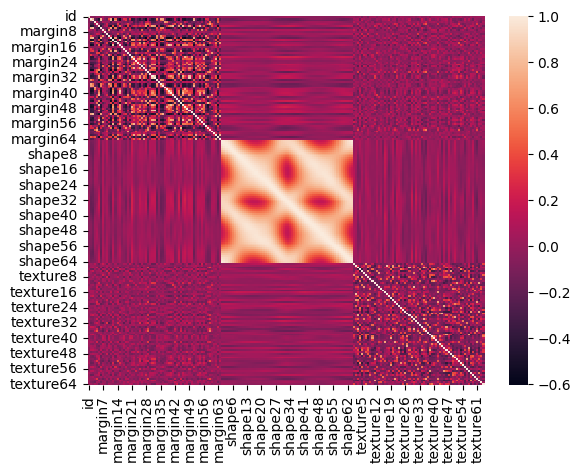

In [6]:
import seaborn as sns

correlation = data.corr(method="pearson", numeric_only=True)
sns.heatmap(correlation)

# Data Description
There are 990 labeled entries in this dataset which we will split into 80% train and 20% test. 

There are no missing values in this data set.

There are 99 unique species as is mentioned by kaggle and they are all present in the labeled data set.

By looking through the dataset we do not need to perfom normalization of any type since all features are within the same range.

## Correlation Matrix

1. High correlation is shown between the the shapes of the different columns, this can be explained by the fact that most of the leaves that are of the same species look the same and as such have a high correlation.

2. The rest of the features do not have strong enough correlation to indicate duplicated features.


In [7]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.io import read_image
from torchvision.utils import save_image
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import math

torch.manual_seed(42)
random.seed(42)
%matplotlib inline

PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

990
5
Acer_Pictum


c:\Users\inass\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


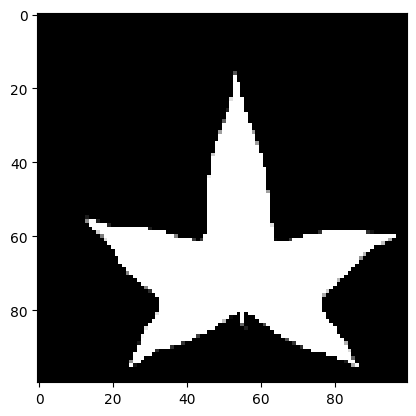

In [8]:
class SquarePad:
	def __call__(self, image):
		_, w, h = image.shape
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return F.pad(image, padding, 'constant')

t = transforms.Compose([transforms.ToTensor(),transforms.Grayscale(num_output_channels=1), SquarePad(), transforms.Resize((100, 100))])
data = ImageFolder("data", transform=t)

print(len(data))

image, label = data[50]
print(label)
print(data.classes[label])
plt.imshow(transforms.functional.to_pil_image(image), cmap="gray")

len_train = int(len(data)*0.8)
len_test = len(data) - len_train
train_set, test_set = torch.utils.data.random_split(data, [len_train, len_test])



In [9]:
# This cell was made to figure out how to best resize the images.

img, _ = data[0]

minW = img.shape[1]
meanW = 0
maxW = img.shape[1]

minH = img.shape[2]
meanH = 0
maxH = img.shape[2]

count = 0

for i in range(len(data)):
    img, _ = data[i]
    if img.shape[1] < minW:
        minWidthImage = img
        minW = img.shape[1]
    if img.shape[1] > maxW:
        maxWidthImage = img
        maxW = img.shape[1]
    if img.shape[2] < minH:
        minH = img.shape[2]
    if img.shape[2] > maxH:
        maxH = img.shape[2]
    meanW = meanW + img.shape[1]
    meanH = meanH + image.shape[2]
    count = count + 1

print("min width", minW)
print("mean width", meanW / count)
print("max width", maxW)

print("min height", minH)
print("mean height", meanH / count)
print("max height", maxH)

min width 100
mean width 100.0
max width 100
min height 100
mean height 100.0
max height 100


In [10]:
def createRes(input_channels):
    return nn.Sequential(
        nn.Upsample(scale_factor=2),
        nn.Conv2d(input_channels, input_channels, 3, stride=1, padding=1),
        nn.BatchNorm2d(input_channels),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2)
    )

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # [1, 100, 100]
        self.batchNorm = nn.BatchNorm2d(1)
        self.res1 = createRes(1)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 12, 3, stride=1, padding=1), # [12, 100, 100]
            nn.ReLU(),
            nn.Conv2d(12, 24, 3, stride=1, padding=1), # [24, 100, 100]
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # [12, 50, 50]
        )
        self.res2 = createRes(24) # [12, 50, 50]
        self.conv2 = nn.Sequential(
            nn.Conv2d(24, 48, 3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(48, 80, 3, stride=1, padding=1), # [80, 50, 50]
            nn.ReLU(),
            nn.MaxPool2d(2, 2) 
        )
        self.res3 = createRes(80) # [80, 25, 25]
        self.conv3 = nn.Sequential(
            nn.Conv2d(80, 100, 3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(100, 200, 3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(5, 5),  # [100, 5, 5]
            nn.Flatten()
        )
        self.linear = nn.Sequential(
            nn.Linear(5000, 2000),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(2000,99),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = self.batchNorm(x)
        out = self.res1(x) + x
        out = self.conv1(out)
        out = self.res2(out) + out
        out = self.conv2(out)
        out = self.res3(out) + out
        out = self.conv3(out)
        out = self.linear(out)
        return out
        

In [11]:
classifier = Classifier()
out = classifier(image.unsqueeze(0))
print(out.shape)
print(out)

torch.Size([1, 99])
tensor([[0.0098, 0.0101, 0.0091, 0.0099, 0.0097, 0.0098, 0.0105, 0.0110, 0.0099,
         0.0097, 0.0109, 0.0107, 0.0112, 0.0102, 0.0104, 0.0102, 0.0095, 0.0106,
         0.0107, 0.0101, 0.0100, 0.0098, 0.0100, 0.0099, 0.0095, 0.0103, 0.0095,
         0.0096, 0.0095, 0.0098, 0.0093, 0.0103, 0.0113, 0.0096, 0.0104, 0.0097,
         0.0106, 0.0093, 0.0100, 0.0105, 0.0101, 0.0110, 0.0091, 0.0101, 0.0099,
         0.0096, 0.0106, 0.0098, 0.0094, 0.0095, 0.0104, 0.0103, 0.0109, 0.0099,
         0.0100, 0.0101, 0.0095, 0.0102, 0.0105, 0.0096, 0.0104, 0.0099, 0.0098,
         0.0100, 0.0093, 0.0100, 0.0100, 0.0101, 0.0103, 0.0121, 0.0100, 0.0104,
         0.0108, 0.0102, 0.0105, 0.0103, 0.0105, 0.0103, 0.0107, 0.0099, 0.0107,
         0.0096, 0.0110, 0.0101, 0.0107, 0.0103, 0.0104, 0.0095, 0.0092, 0.0105,
         0.0102, 0.0103, 0.0106, 0.0094, 0.0097, 0.0103, 0.0098, 0.0092, 0.0095]],
       grad_fn=<SoftmaxBackward0>)


In [12]:
def getDevice():
    if torch.cuda.is_available():
        return "cuda"
    else:
        return "cpu"

device = getDevice()

if device == "cuda":
    torch.cuda.empty_cache()
classifier.to(device)

print(device)

cuda


In [13]:
def train(model, epochs, batch_size, patience = 5, delta=0.02):
    dataloader = DataLoader(train_set, batch_size, shuffle=True)
    testloader = DataLoader(test_set, batch_size, shuffle=True)

    opt = torch.optim.Adam(model.parameters(), lr = 0.00015)
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, 0.008, epochs= epochs, steps_per_epoch= math.ceil(len(train_set) / batch_size))
    trainLosses = []
    valLosses = []
    lossFunc = nn.CrossEntropyLoss()

    val_counter = 0
    min_val = float("inf")
    
    for epoch in range(epochs):
        print(f"Starting Epoch {epoch + 1}")
        for images, labels in tqdm(dataloader):
            # do a forward pass
            images = images.to(device)
            opt.zero_grad()
            predictions = model(images)

            # turn the labels into vectors of shape 1, 99
            labels = F.one_hot(labels, num_classes=99,).to(device)
            labels.requires_grad = False

            # calculate the loss
            trainLoss = lossFunc(predictions, labels.float())
            trainLoss.backward()
            opt.step()
            # scheduler.step()
        trainLosses.append(trainLoss.sum().item())

        # calculate validation loss
        with torch.no_grad():
            valLoss = 0
            for images, labels in tqdm(testloader):
                # do a forward pass
                images = images.to(device)
                predictions = model(images)
                # turn the labels into vectors of shape 1, 99
                labels = F.one_hot(labels, num_classes=99,).to(device)
                labels.requires_grad = False

                miniValLoss = lossFunc(predictions, labels.float())
                valLoss = miniValLoss.sum()
            valLosses.append(valLoss.item())
        
        
        print(f"Train Loss {trainLoss} Test Loss {valLoss}")

        # stop if validation is not going down
        if valLoss < min_val + delta:
            min_val = valLoss
            val_counter = 0
        else:
            val_counter = val_counter + 1
            if val_counter > patience:
                print("Early Stopping...")
                return trainLosses, valLosses
            
        
    return trainLosses, valLosses

losses = train(classifier, 300, 512, 5, 0.02)

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Train Loss 4.300940990447998 Test Loss 4.486014366149902
Starting Epoch 298


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Train Loss 4.301007270812988 Test Loss 4.485187530517578
Starting Epoch 299


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Train Loss 4.290106296539307 Test Loss 4.485803127288818
Starting Epoch 300


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

Train Loss 4.293792724609375 Test Loss 4.486023426055908


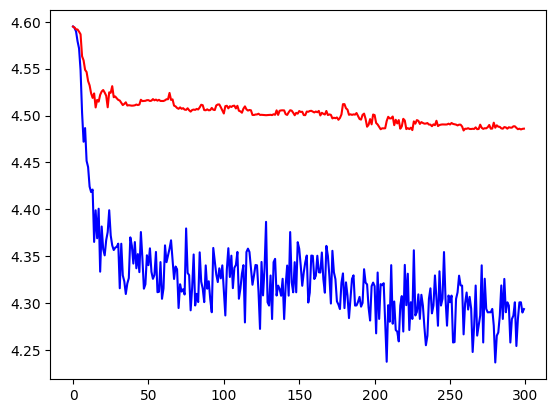

In [14]:
plt.plot(range(len(losses[0])), losses[0], "b")
plt.plot(range(len(losses[0])), losses[1], "r")
plt.show()

In [15]:
def calculateAccuracy(model, set):
    count = 0
    total = 0
    minPredicted = 100
    maxPredicted = -1
    with torch.no_grad():
        for image, label in set:
            prediction = model(image.unsqueeze(0).to(device))
            predicted_label = torch.argmax(prediction).item()
            if predicted_label == label:
                count = count + 1
            if minPredicted > predicted_label:
                minPredicted = predicted_label
            if maxPredicted < predicted_label:
                maxPredicted = predicted_label
            total = total + 1
    return (count / total) * 100

print(f"accuracy train {calculateAccuracy(classifier, train_set)}")
print(f"accuracy test {calculateAccuracy(classifier, test_set)}")

accuracy train 32.57575757575758
accuracy test 12.626262626262626
